In [1]:
'''Example of VAE on MNIST dataset using MLP

The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.

# Reference

[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
import seaborn

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('paper')
from matplotlib.colors import ListedColormap
cmap1 = ListedColormap(sns.color_palette().as_hex())
cmap2 = ListedColormap(sns.color_palette('bright').as_hex())
def plot(x, y=None, x2=None, y2=None, s=10, alpha=0.5, label1=None, label2=None, cmap1=None, cmap2=None):
    n = x.shape[1]
    if n == 1:
        g = plt.figure()
        plt.scatter(np.zeros((n,)), x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(np.zeros((n,)), x2[:,1], c=y2, s=s, alpha=alpha, label=label2, cmap=cmap2)
    if n == 3:
        %matplotlib notebook
        g = plt.figure()
        ax = g.add_subplot(111, projection='3d')
        ax.scatter(x[:,0], x[:,1], x[:,2], c=y, s=s, alpha=alpha, label=label1)
        if x2 is not None:
            ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=s, alpha=alpha, label=label2)
    elif n == 784:
        %matplotlib inline
        n_imgs = 10
        # num = 7
        # sub = y == num
        sub = y == y
        for i in range(n_imgs):
            idx = np.random.randint(len(x[sub]))
            if x2 is not None:
                plt.subplot(1,2,1)
                plt.imshow(x2[sub][idx].reshape(28, 28))
            plt.subplot(1,2,2)
            plt.imshow(x[sub][idx].reshape(28, 28))
            g = plt.figure()
    else:
        g = plt.figure()
        plt.scatter(x[:,0], x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(x2[:,0], x2[:,1], c=y2, s=s, alpha=alpha, label=label2, cmap=cmap2)
            
    if label1 is not None or label2 is not None:
        plt.legend()
        
    return g

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# MNIST dataset
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# image_size = x_train.shape[1]
# original_dim = image_size * image_size
# x_train = np.reshape(x_train, [-1, original_dim])
# x_test = np.reshape(x_test, [-1, original_dim])
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255

In [4]:
def generate_loop(n=1200, train_set_fraction=.8):
    t = np.linspace(0, 2*np.pi, num=n)
    
    # generate all three coordinates
    x = np.empty((n, 3))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(2*t)
    x[:,2] = np.sin(3*t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_circle(n=200, train_set_fraction=.8, alpha=4):
#     t = np.linspace(0, 2*np.pi, num=n)
    t = np.log(np.linspace(1, alpha, num=n))
    t = t / np.max(t) * 2 * np.pi
    
    # generate all three coordinates
    x = np.empty((n, 2))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_line(n=1200, train_set_fraction=.8):
    pts_per_cluster = int(n / 2)
    x1 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x2 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x = np.concatenate([x1, x2], axis=1)
    
    # generate labels
#     y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)
    y = x1
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_gaussians(n=1200, n_clusters=2, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / n_clusters)
    r = 1
    
    clusters = []
    
    for x in np.linspace(0, 1, num=n_clusters):
        clusters.append(np.random.normal(x, noise_sigma, size=(pts_per_cluster, 2)))

    # combine clusters
    x = np.concatenate(clusters, axis=0)
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_cc(n=1200, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / 2)
    r = 1

    # generate clusters
    theta1 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)
    theta2 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)

    cluster1 = np.concatenate((np.cos(theta1) * r, np.sin(theta1) * r), axis=1)
    cluster2 = np.concatenate((np.cos(theta2) * r, np.sin(theta2) * r), axis=1)

    # shift and reverse cluster 2
    cluster2[:, 0] = -cluster2[:, 0] + 0.5
    cluster2[:, 1] = -cluster2[:, 1] - 1

    # combine clusters
    x = np.concatenate((cluster1, cluster2), axis=0)

    # add noise to x
    x = x + np.random.randn(x.shape[0], 2) * noise_sigma
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

In [5]:
dataset = 'loop'

if dataset == 'mnist':
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255
    latent_dim = 10
elif dataset == 'gaussians':
    (x_train, y_train), (x_test, y_test) = generate_gaussians(n=2000, n_clusters=1, train_set_fraction=0.85)
    latent_dim = 6
elif dataset == 'line':
    (x_train, y_train), (x_test, y_test) = generate_line(n=2000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=1000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'cc':
    (x_train, y_train), (x_test, y_test) = generate_cc(n=2000, noise_sigma=0.1, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'circle':
    (x_train, y_train), (x_test, y_test) = generate_circle(n=256, train_set_fraction=0.85, alpha=30)
    latent_dim = 3

# normalize to between -1 and 1
if dataset != 'mnist':
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b
print('IMPORTANT: max {}, min {}'.format(np.max(x_train), np.min(x_train)))

IMPORTANT: max 1.0, min -1.0


In [6]:
# (x_train, y_train), (x_test, y_test) = generate_circle(n=256, train_set_fraction=0.85, alpha=30)
original_dim = x_train.shape[1]

# network parameters
input_shape = (original_dim, )
# intermediate_dims = [512, 512, 2048]
intermediate_dims = [512]
batch_size = 128
epochs = 200

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for dim in intermediate_dims:
    x = Dense(dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = latent_inputs
for dim in intermediate_dims[::-1]:
    x = Dense(dim, activation='relu')(x)
outputs = Dense(original_dim, activation='linear')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 3)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2048        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
_____________________________________

In [7]:
models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = 1 + z_log_var - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae_loss = K.mean(reconstruction_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 3)                 0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4100      
_________________________________________________________________
decoder (Model)              (None, 3)                 3075      
Total params: 7,175
Trainable params: 7,175
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 850 samples, validate on 150 samples
Epoch 1/200
850/850 [==============================] - 1s 1ms/step - loss: 1.4936 - val_loss: 1.5010
Epoch 2/200
850/850 [==============================] - 0s 43us/step - loss: 1.4509 - val_loss: 1.4626
Epoch 3/200
850/850 [==============================] - 0s 49us/step - loss: 1.3560 - val_loss: 1.3637
Epoch

850/850 [==============================] - 0s 51us/step - loss: 0.1727 - val_loss: 0.1955
Epoch 71/200
850/850 [==============================] - 0s 52us/step - loss: 0.1729 - val_loss: 0.1895
Epoch 72/200
850/850 [==============================] - 0s 52us/step - loss: 0.1753 - val_loss: 0.1829
Epoch 73/200
850/850 [==============================] - 0s 53us/step - loss: 0.1760 - val_loss: 0.1947
Epoch 74/200
850/850 [==============================] - 0s 52us/step - loss: 0.1762 - val_loss: 0.1994
Epoch 75/200
850/850 [==============================] - 0s 52us/step - loss: 0.1734 - val_loss: 0.2017
Epoch 76/200
850/850 [==============================] - 0s 53us/step - loss: 0.1751 - val_loss: 0.1853
Epoch 77/200
850/850 [==============================] - 0s 53us/step - loss: 0.1698 - val_loss: 0.2030
Epoch 78/200
850/850 [==============================] - 0s 52us/step - loss: 0.1759 - val_loss: 0.1901
Epoch 79/200
850/850 [==============================] - 0s 52us/step - loss: 0.1701 - 

850/850 [==============================] - 0s 52us/step - loss: 0.1244 - val_loss: 0.1400
Epoch 150/200
850/850 [==============================] - 0s 53us/step - loss: 0.1196 - val_loss: 0.1447
Epoch 151/200
850/850 [==============================] - 0s 51us/step - loss: 0.1243 - val_loss: 0.1377
Epoch 152/200
850/850 [==============================] - 0s 53us/step - loss: 0.1249 - val_loss: 0.1328
Epoch 153/200
850/850 [==============================] - 0s 53us/step - loss: 0.1247 - val_loss: 0.1588
Epoch 154/200
850/850 [==============================] - 0s 52us/step - loss: 0.1245 - val_loss: 0.1586
Epoch 155/200
850/850 [==============================] - 0s 53us/step - loss: 0.1145 - val_loss: 0.1301
Epoch 156/200
850/850 [==============================] - 0s 52us/step - loss: 0.1191 - val_loss: 0.1517
Epoch 157/200
850/850 [==============================] - 0s 52us/step - loss: 0.1219 - val_loss: 0.1395
Epoch 158/200
850/850 [==============================] - 0s 53us/step - loss: 

<IPython.core.display.Javascript object>


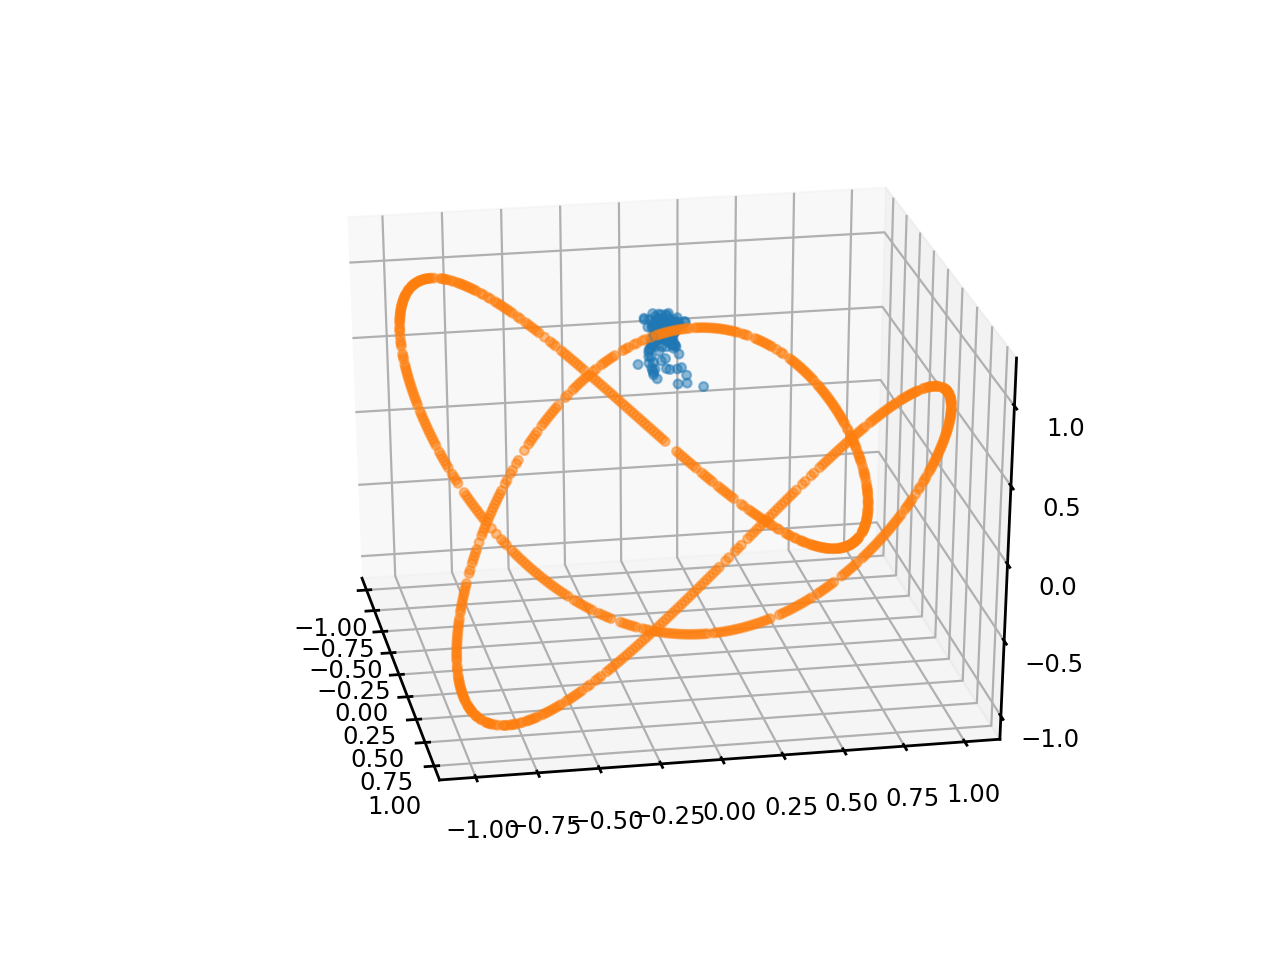

In [19]:
x_hat = vae.predict(np.array([x_test[0]]*300))
g = plot(x=x_hat, x2=x_train)

<IPython.core.display.Javascript object>


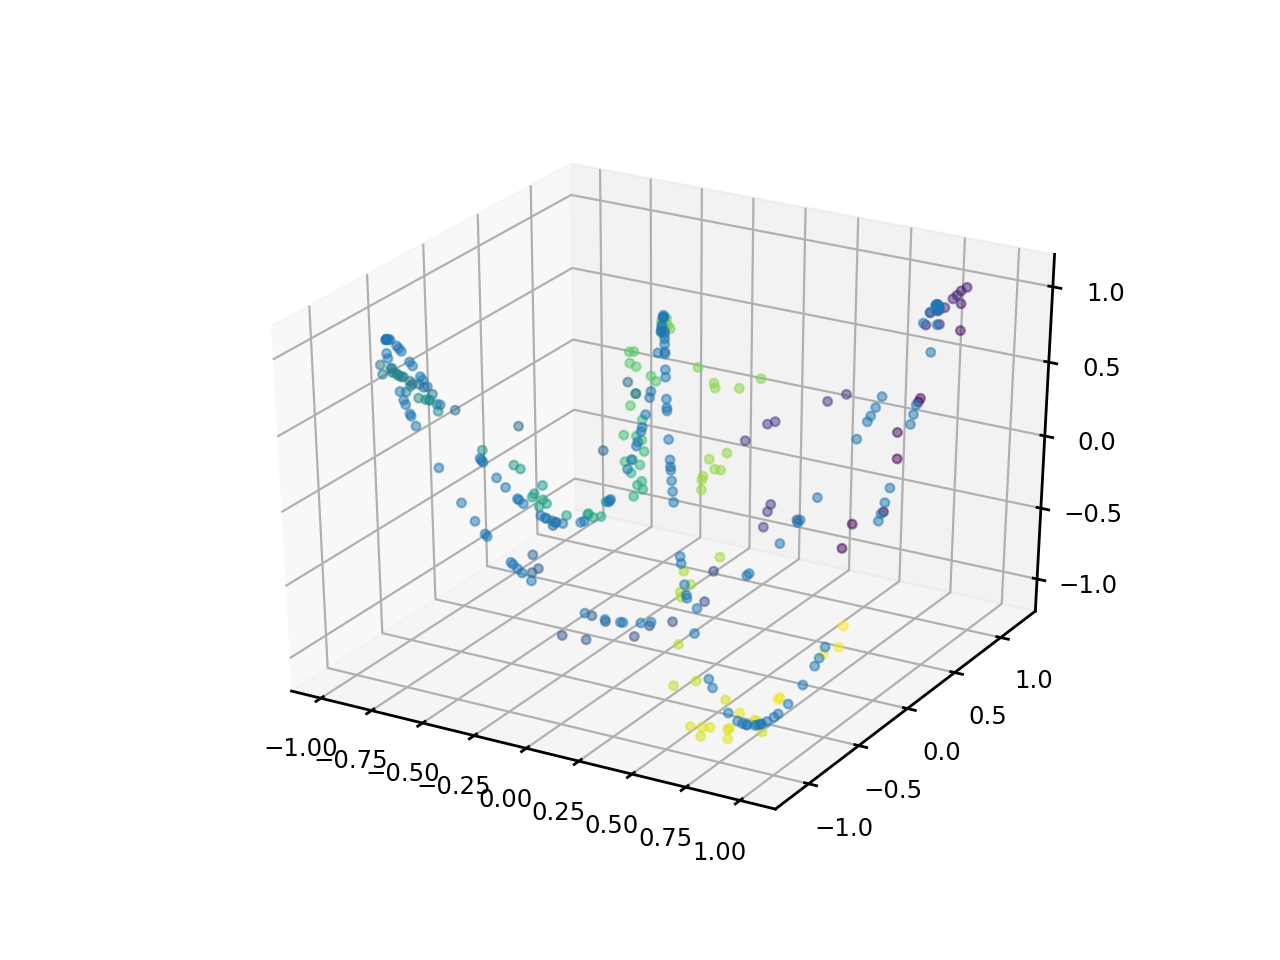

In [18]:
x_hat = vae.predict(x_test)
g = plot(x=x_hat, y=y_test, x2=x_test)

<IPython.core.display.Javascript object>


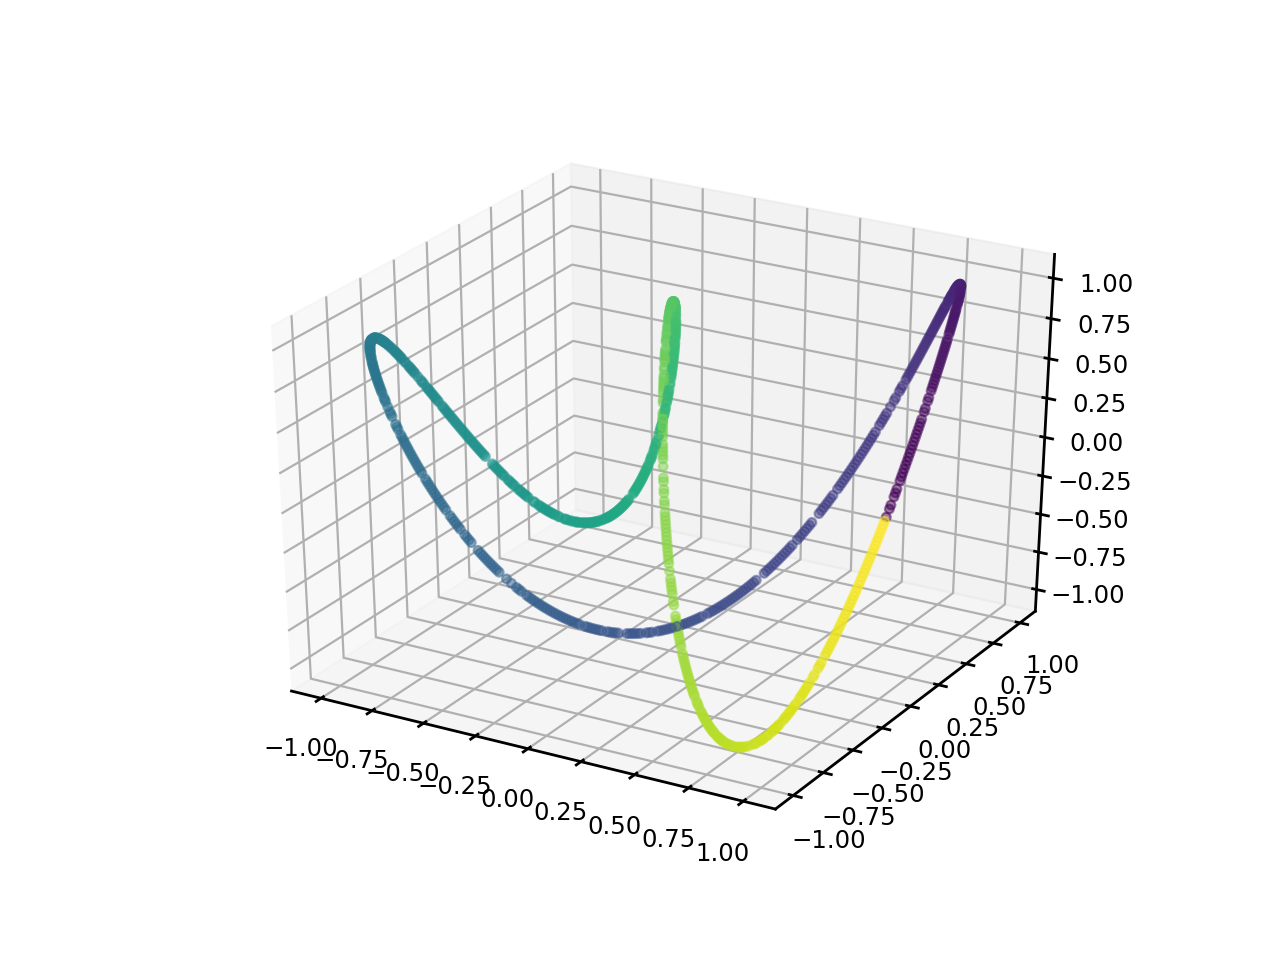

In [17]:
g = plot(x=x_train, y=y_train)

<IPython.core.display.Javascript object>


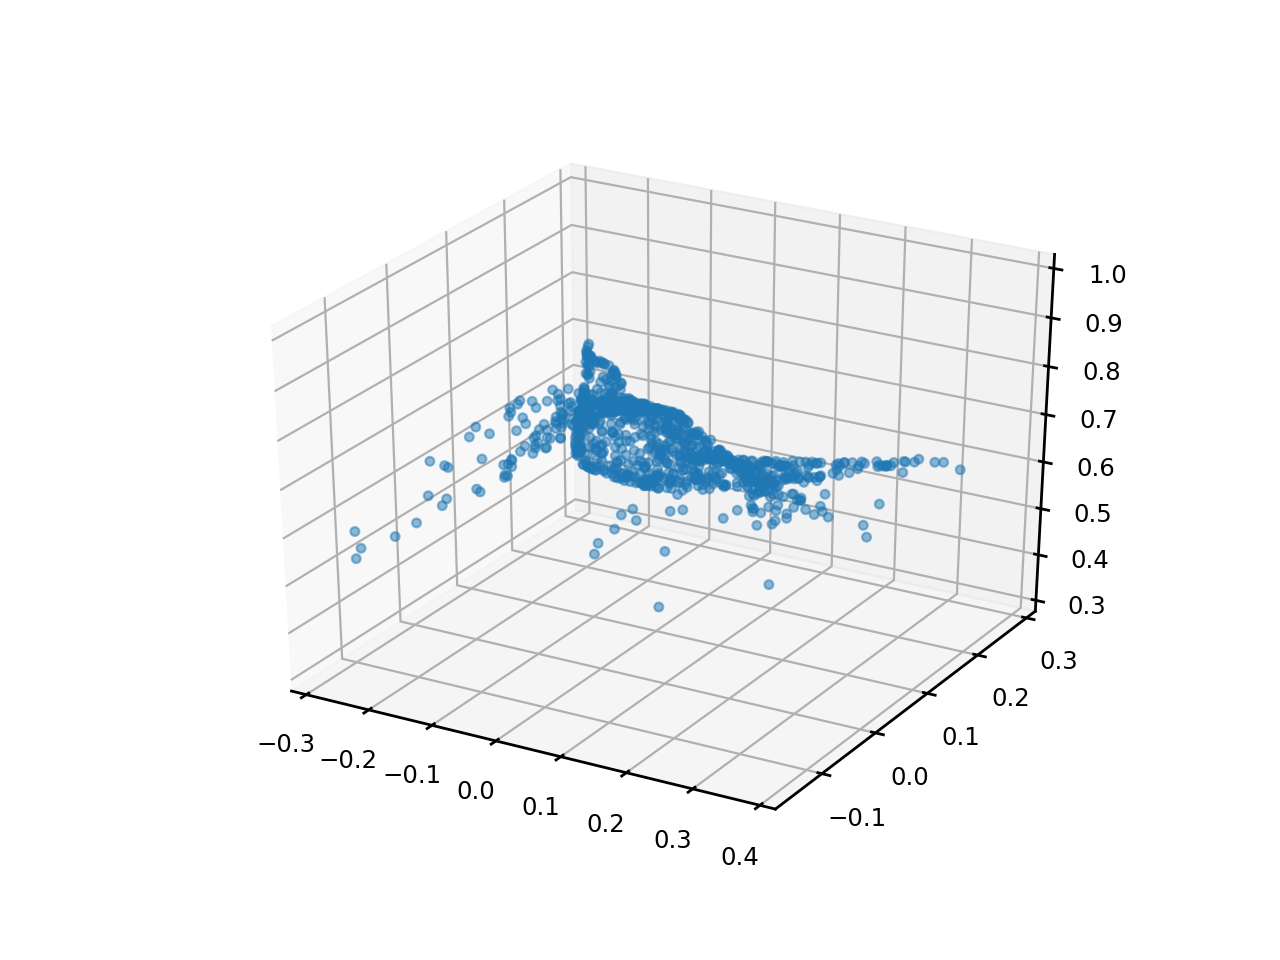

In [16]:
n_ = 1000
z_sample = np.random.normal(size=(n_, latent_dim))
x_decoded = decoder.predict(z_sample)
g = plot(x=x_decoded)

<IPython.core.display.Javascript object>


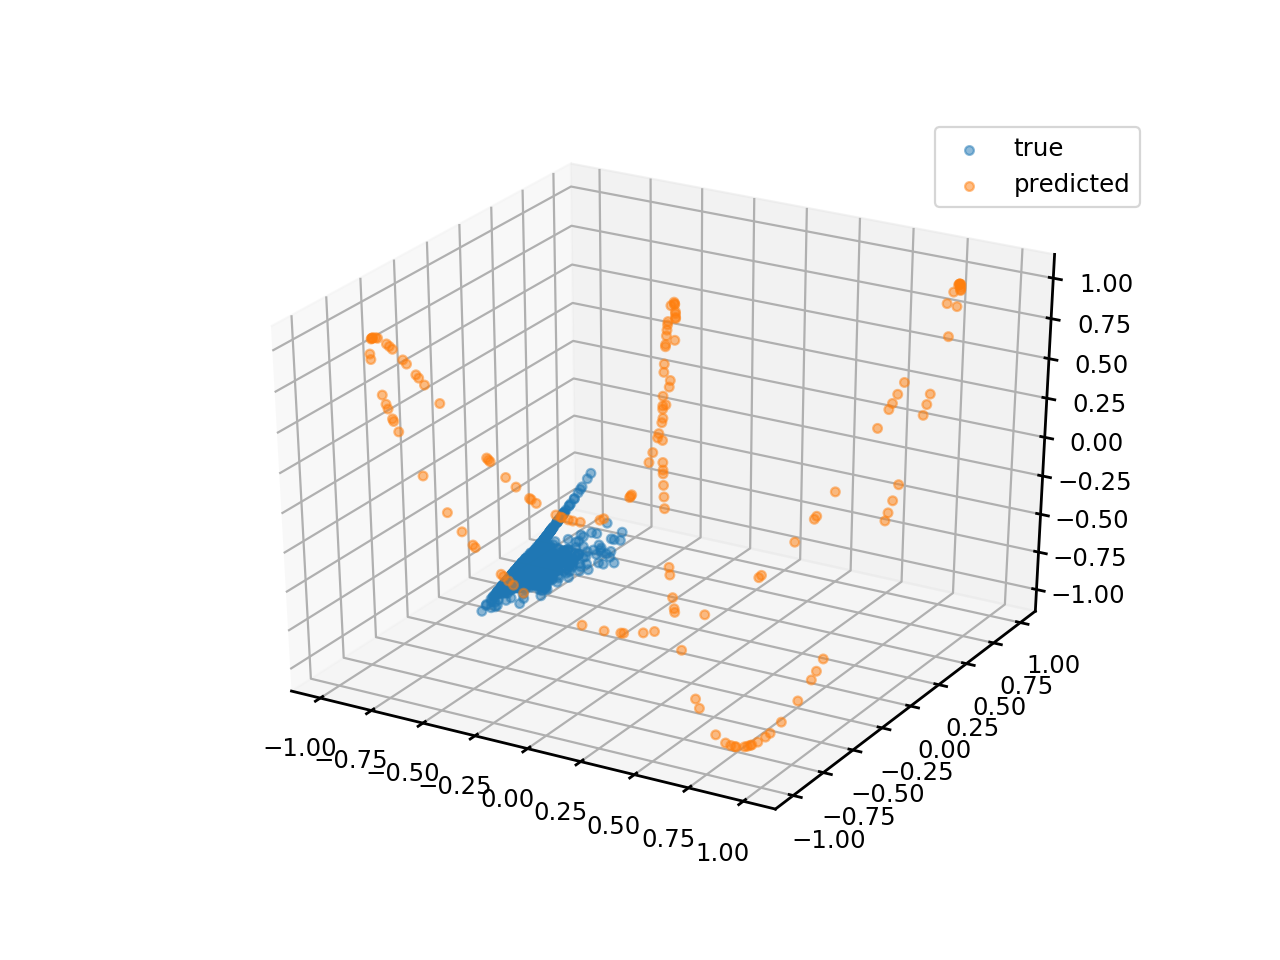

In [12]:
# create burst from a point and compute covariance matrix
burst_size = 1000
rand_idx = np.random.randint(len(x_test))
x_ = x_test[rand_idx]
# x_ = np.array((np.cos(.25), np.sin(.25)))
x_arr = np.array([x_] * burst_size)
x_rec = vae.predict(x_arr)
g = plot(x_rec, x2=x_test, label1='true', label2='predicted')

In [13]:
mu, var, z_ = encoder.predict(x_test)

<IPython.core.display.Javascript object>


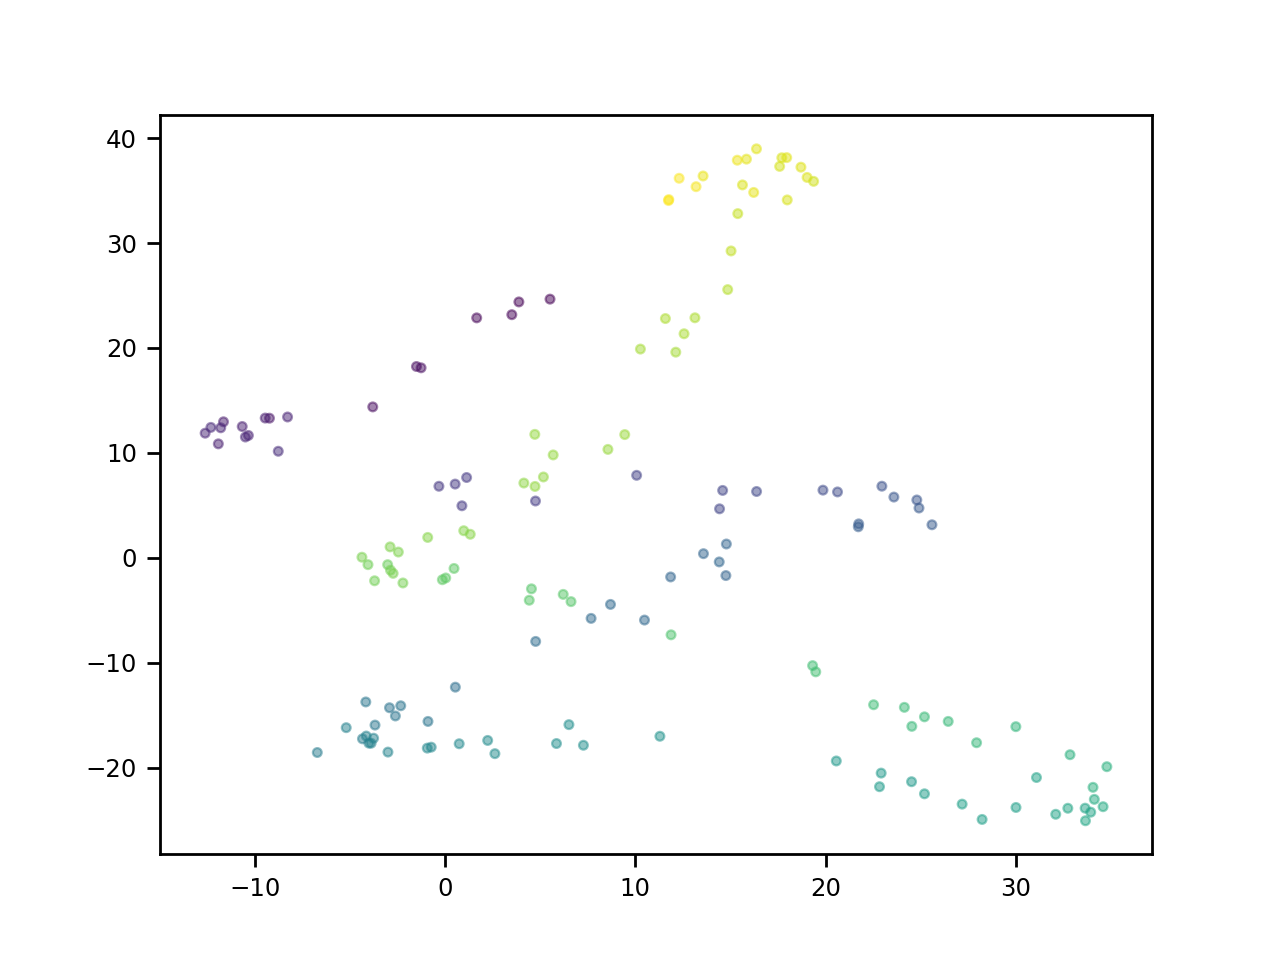

In [14]:
g = plot(z_, y=y_test)

<IPython.core.display.Javascript object>


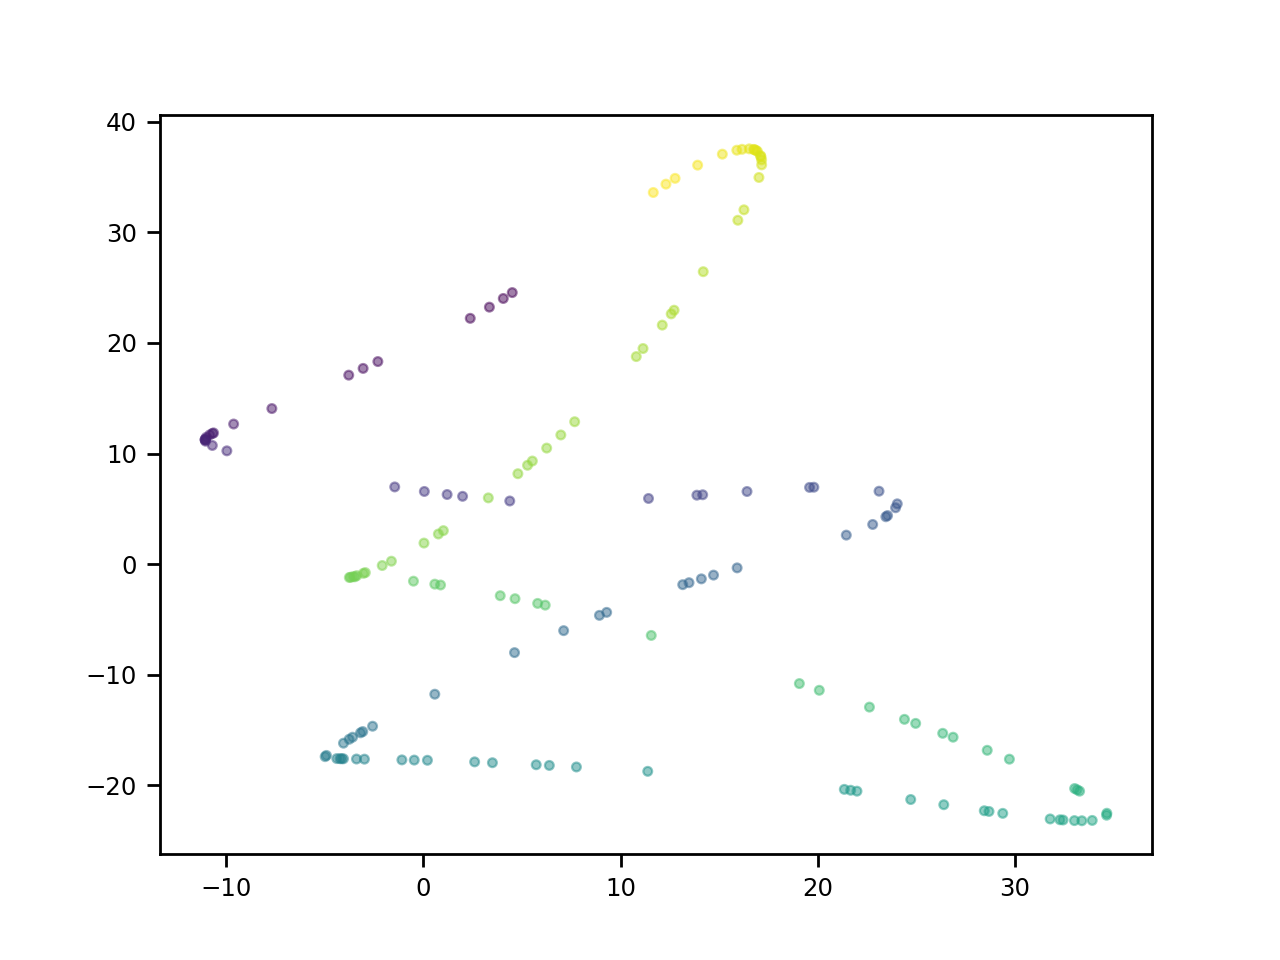

In [15]:
g = plot(mu, y=y_test)